<img src="../Images/pokemon-img.jpg">

# CNN on Pokémon Images
This network trains on the [Kaggle dataset](https://www.kaggle.com/lantian773030/pokemonclassification). It identifies each type of Pokémon: Bug, Dragon, Electric, Fairy, Fighting, Fire, Ghost, Grass, Ground, Ice, Normal, Poison, Psychic, Rock, and Water. Note that this dataset does not contain every Pokémon and thus missing 3 more types: Dark, Flying, and Steel.

### Standard Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import splitfolders
import os
from PIL import Image
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Next, I sorted each Pokémon image into 15 different folders organized by type using [shutil](https://docs.python.org/3/library/shutil.html). Note that most Pokémon have multiple types. So, I made the decision to only sort a Pokémon into that type when it is Pure or Primary and thus ignoring their Secondary type. This information was obtained from the [Pokémon Wiki](https://pokemon.fandom.com/wiki/Types).

### Define Transformations
Here, we combine data augmentation and normalization. 

In [2]:
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

Example of transformation applied to image:

(324, 450)


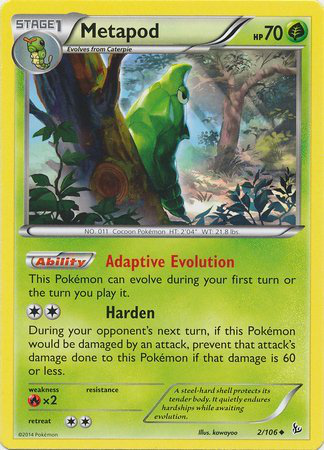

In [3]:
metapod = Image.open('../Data/Pokemon/test/Bug/144d46cee3624f61828716b965faaf05.jpg')
print(metapod.size)
display(metapod)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 240, 240])


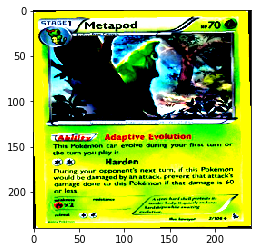

In [4]:
transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])
im = transform(metapod)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### Prepare Test and Train Sets, Loaders
First, split the dataset into different train and test folders using [split-folders](https://pypi.org/project/split-folders/).

splitfolders.ratio('../Data/Pokemon_Types', output='../Data/Pokemon', seed=1337, ratio=(.8, .2), group_prefix=None) 

In [5]:
root = '../Data/Pokemon'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform = test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['Bug', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Water']
Training images available: 8522
Testing images available:  2135


In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

### Define Model

Here, we have a multi-classfication problem with a total of 15 output channels.

In [7]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.conv3 = nn.Conv2d(12, 24, 3, 1)
        self.fc1 = nn.Linear(28*28*24, 60)
        self.fc2 = nn.Linear(60, 48)
        self.fc3 = nn.Linear(48, 15)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 28*28*24)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [8]:
torch.manual_seed(101)
Pokemon_model = ConvolutionalNetwork()
Pokemon_model.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=18816, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=48, bias=True)
  (fc3): Linear(in_features=48, out_features=15, bias=True)
)

### Define Loss and Optimization Functions

In [9]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(Pokemon_model.parameters(), lr=0.001)

### Train Model

In [10]:
import time
start_time = time.time()

epochs = 27

# Trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        y_pred = Pokemon_model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tracking correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print epoch and loss results
        if b%100==0:
            print(f'EPOCH: {i}  LOSS: {loss.item():10.8f}')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
            X_test = X_test.to(device)
            y_test = y_test.to(device)

            y_val = Pokemon_model(X_test)

            # Tracking correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {(time.time() - start_time)/60} minutes')    

EPOCH: 0  LOSS: 1.82510722
EPOCH: 1  LOSS: 1.63492095
EPOCH: 2  LOSS: 1.87823677
EPOCH: 3  LOSS: 1.92546415
EPOCH: 4  LOSS: 1.41876483
EPOCH: 5  LOSS: 1.49705446
EPOCH: 6  LOSS: 1.49296129
EPOCH: 7  LOSS: 1.70146978
EPOCH: 8  LOSS: 1.45773578
EPOCH: 9  LOSS: 1.12816107
EPOCH: 10  LOSS: 1.51921868
EPOCH: 11  LOSS: 1.15655756
EPOCH: 12  LOSS: 1.21770120
EPOCH: 13  LOSS: 1.40161896
EPOCH: 14  LOSS: 1.40769291
EPOCH: 15  LOSS: 1.18354356
EPOCH: 16  LOSS: 1.13440394
EPOCH: 17  LOSS: 0.97522014
EPOCH: 18  LOSS: 1.26629758
EPOCH: 19  LOSS: 0.93831015
EPOCH: 20  LOSS: 0.89174020
EPOCH: 21  LOSS: 0.89997035
EPOCH: 22  LOSS: 0.84657019
EPOCH: 23  LOSS: 1.04774976
EPOCH: 24  LOSS: 0.79712409
EPOCH: 25  LOSS: 0.90790510
EPOCH: 26  LOSS: 0.74412745

Duration: 56.096892730395 minutes


In [11]:
torch.save(Pokemon_model.state_dict(), 'PokemonModel.pt')

### Model Performance

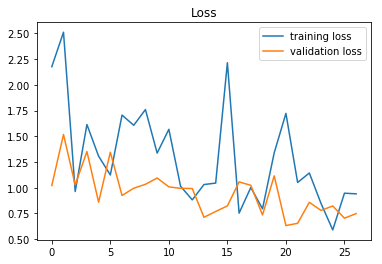

In [12]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss')
plt.legend();

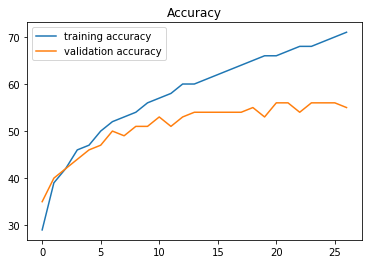

In [13]:
plt.plot([t/85 for t in train_correct], label='training accuracy')
plt.plot([t/21 for t in test_correct], label='validation accuracy')
plt.title('Accuracy')
plt.legend();

Test Accuracy

In [14]:
(test_correct[-1].item()/2135)*100

54.894613583138174

## Examining Hits and Misses

In [15]:
use_cuda = False
device = torch.device('cuda:0' if use_cuda else 'cpu')
device

device(type='cpu')

In [16]:
Pokemon_model.to(device)
Pokemon_model.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=18816, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=48, bias=True)
  (fc3): Linear(in_features=48, out_features=15, bias=True)
)

I want to display the original image so I took the inverse of the normalization and applied it to the dataset.

In [17]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225])

In [18]:
misses = np.array([])

for i in range(len(predicted.view(-1))):
    
    predicted = predicted.to(device)
    y_test = y_test.to(device)
    
    if predicted[i] != y_test[i]:
        misses = np.append(misses, i).astype('int64')

In [19]:
r = 5 
row = iter(np.array_split(misses,len(misses)//r+1))

Label: [   14    14    14]
Real Class:  Water Water Water

Guess: [    0     4    11]
Predicted Class:  Bug Fighting Poison


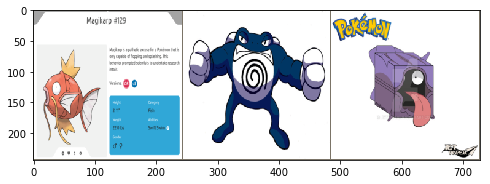

In [20]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))

nextrow = next(row)
next_row = torch.tensor(nextrow).to(device)
X_test = X_test.to(device)

lbls = y_test.index_select(0, next_row).numpy()
gues = predicted.index_select(0, next_row).numpy()
print("Label:", lbls)
print("Real Class: ", *np.array([class_names[i] for i in lbls]))
print()
print("Guess:", gues)
print("Predicted Class: ", *np.array([class_names[i] for i in gues]))

images = X_test.index_select(0, next_row)
im = make_grid(images, nrow = r)
im = inv_normalize(im)
plt.figure(figsize = (8, 4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

Now, let's see what the model predicted correctly.

In [27]:
hits = np.array([])

for i in range(len(predicted.view(-1))):
    
    predicted = predicted.to(device)
    y_test = y_test.to(device)
    
    if predicted[i] == y_test[i]:
        hits = np.append(hits,i).astype('int64')

In [28]:
r = 5
row = iter(np.array_split(hits, len(hits)//r+1))

Label: [   14    14    14    14    14]
Real Class:  Water Water Water Water Water

Guess: [   14    14    14    14    14]
Predicted Class:  Water Water Water Water Water


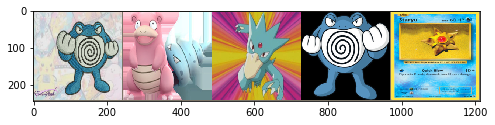

In [29]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))

nextrow = next(row)
next_row = torch.tensor(nextrow).to(device)
X_test = X_test.to(device)

lbls = y_test.index_select(0, next_row).numpy()
gues = predicted.index_select(0, next_row).numpy()
print("Label:", lbls)
print("Real Class: ", *np.array([class_names[i] for i in lbls]))
print()
print("Guess:", gues)
print("Predicted Class: ", *np.array([class_names[i] for i in gues]))

images = X_test.index_select(0, next_row)
im = make_grid(images, nrow = r)
im = inv_normalize(im)
plt.figure(figsize = (8, 4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Conclusion
I played around with the learning rate, number of convolutional layers, different combinations of transformations, number of epochs, and number of filters. This was the best the model can perform. In the future, I would be curious if this model would get better with more data. 

## Acknowledgements 
Most of this code I learned from [Jose Portilla's Course on Pytorch](https://www.udemy.com/course/pytorch-for-deep-learning-with-python-bootcamp/). I just adapted the code to better fit this dataset. Thanks for going through my notebook :) 